In [1]:
import time
import os
import glob
import numpy  as np
import tables as tb
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer

In [2]:
plt.rcParams["font.size"]      = 15
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"

In [3]:
get_file_number = lambda filename: int(filename.split("/")[-1].split("_")[1])

datadir = os.path.expandvars("$HOME/NEXT/DATA/psf/")
filenames = sorted(glob.glob(datadir + "*.h5"), key=get_file_number)

filenames[:4]

['/Users/gonzalo/NEXT/DATA/psf/nexus_0_psf.h5',
 '/Users/gonzalo/NEXT/DATA/psf/nexus_1_psf.h5',
 '/Users/gonzalo/NEXT/DATA/psf/nexus_2_psf.h5',
 '/Users/gonzalo/NEXT/DATA/psf/nexus_3_psf.h5']

In [4]:
#### Configuration Params ####

# configure z binning
el_gap_width = 10.
dz    = 1.
zbins = np.arange(0, el_gap_width + dz, dz)

# configure transverse binning
dd    = 1
dmax  = 500
dbins = np.arange(0, dmax + dd, dd)

In [5]:
df = pd.DataFrame()
df["d_bin"]   = dbins[:-1]
df["charge"]  = np.zeros(len(dbins)-1)
df["entries"] = np.zeros(len(dbins)-1)
df = df.set_index("d_bin")
# saved data
dfs = dict()
for z in zbins[:-1]: dfs[z] = df.copy()    
nevents = dict()
for z in zbins[:-1]: nevents[z] = 0

detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, 0)

nphotons_in_file = []

In [6]:
t0 = time.time()

for i, filename in enumerate(filenames):
    
    print("Processing file:", i+1, "/", len(filenames), end="\r")
    
    configuration = pd.read_hdf(filename, "/MC/configuration").set_index("param_key")
    particles     = pd.read_hdf(filename, "/MC/particles/")
    sns_response  = pd.read_hdf(filename, "/MC/sns_response")
    sns_positions = pd.read_hdf(filename, "/MC/sns_positions")

    Nphotons = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])
    nphotons_in_file.append(Nphotons)
    
    # select SIPMs
    sns_response = sns_response[np.isin(sns_response["sensor_id"], datasipm["SensorID"])]
    for event_id, particle in particles.groupby("event_id"):
        x = particle["initial_x"].values
        y = particle["initial_y"].values
        z = particle["initial_z"].values

        # distances from emission point
        distances_df          = pd.DataFrame.copy(datasipm.drop(["ChannelID", "adc_to_pes", "Sigma"], axis=1))
        distances_df["d"]     = ((distances_df["X"]-x)**2 + (distances_df["Y"]-y)**2)**0.5
        distances_df["d_bin"] = pd.cut(distances_df["d"], bins=dbins, labels=dbins[:-1], include_lowest=True)
        distances_df = distances_df.set_index("SensorID")

        responses = sns_response[sns_response["event_id"]==event_id]

        # charge per sensor
        charges = responses.groupby("sensor_id")["charge"].sum() # protection
        charges = charges.reindex(datasipm["SensorID"], fill_value=0)

        distances_df["charge"] = charges
        total_charge = distances_df.groupby("d_bin")["charge"].sum()
        entries      = distances_df.groupby("d_bin")["d"]     .nunique()

        #fill total df
        zbin = pd.cut(-z, bins=zbins, labels=zbins[:-1])[0]
        if np.isnan(zbin): continue
            
        df = dfs[zbin]
        df["charge"]  = df["charge"]  + total_charge
        df["entries"] = df["entries"] + entries
        dfs[zbin] = df
        
        nevents[zbin] += 1

nphotons_in_file = np.array(nphotons_in_file)
Nphotons = nphotons_in_file[0]
assert np.all(nphotons_in_file == Nphotons)

print(f"Time (total {sum(list(nevents.values()))} events):", (time.time()-t0)/60.)

Time (total 591 events): 0.13721916675567628


In [7]:
psf = pd.DataFrame()
for zbin in dfs:
    psf[zbin] = dfs[zbin]["charge"]/dfs[zbin]["entries"]/Nphotons

In [8]:
signal_type = "S2"

for i, zbin in enumerate(zbins[:-1]):
    psf = psf.rename({zbin: "z_m" + str(int(zbins[i+1]))}, axis=1)

psf = psf.reset_index().rename({"d_bin": "dist_xy"}, axis=1)

In [9]:
if psf.isna().values.any():
    raise Exception("NaN values in table!")

Exception: NaN values in table!

In [17]:
save = True
outfilename = f"PSF.h5"

if save:
    with tb.open_file(outfilename, 'w') as h5out:
        df_writer(h5out, psf, "PSF", "LightTable")

In [18]:
# create PSF config
config = { "detector"   : "next100"
         , "ACTIVE_rad" : str(984./2.) #compulsory
         , "EL_GAP"     : str(10.0)    #compulsory
         , "signal_type": signal_type
         , "sensor"     : "SIPM"       #compulsory
         , "pitch_z"    : str(dz)      #compulsory
         , "nexus"      : "v7_00_00"}
config = pd.DataFrame({"parameter": config.keys(), "value": config.values()})

if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer( h5out, config, "PSF", "Config"
                 , str_col_length = config.applymap(lambda x: len(x)).values.max())

In [19]:
# copy MC configuration
configuration = load_dst(filenames[0], "MC", "configuration")

if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer( h5out, config, "PSF", "configuration"
                 , str_col_length = configuration.applymap(lambda x: len(x)).values.max())

In [20]:
psf    = load_dst(outfilename, "PSF", "LightTable")
config = load_dst(outfilename, "PSF", "Config")

<IPython.core.display.Javascript object>


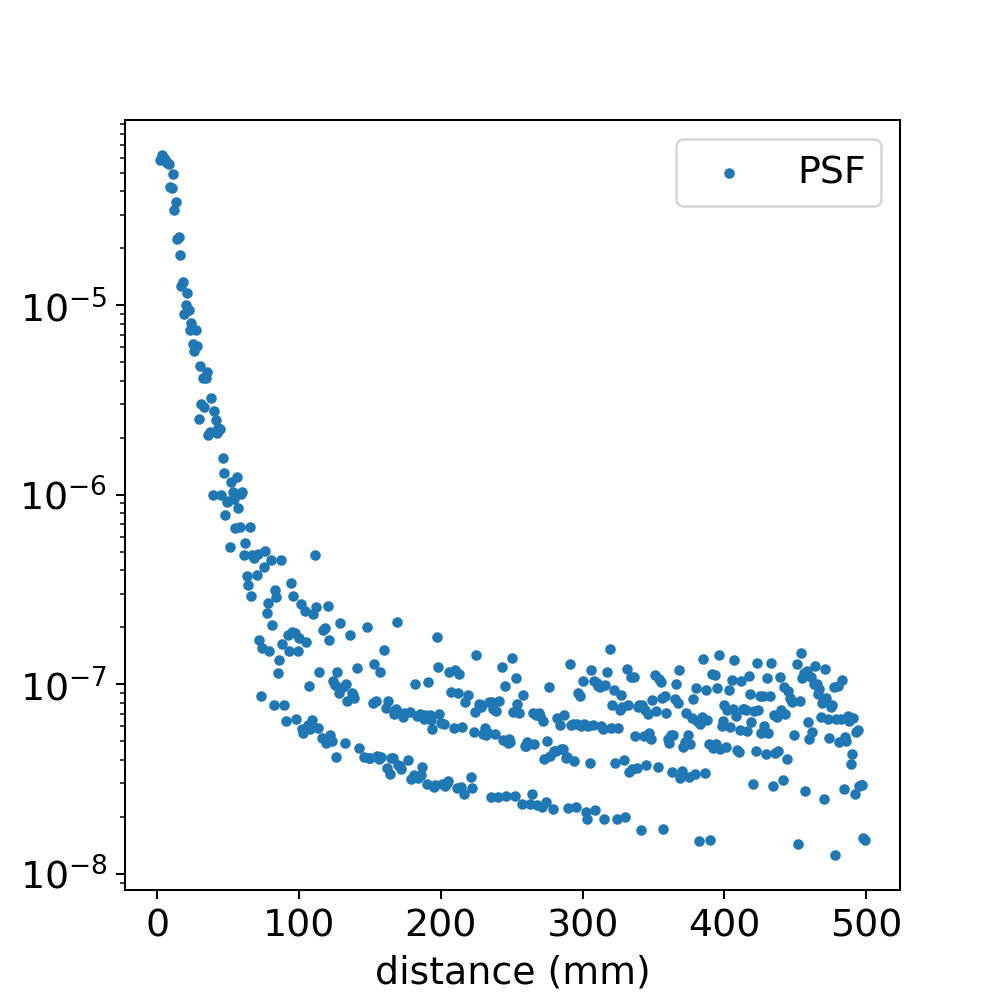

In [22]:
i = 2

fig, ax = plt.subplots(1, figsize=[5.5, 5.5])
ax.scatter(psf.index, psf[f"z_m{i+1}"], s=10, label="PSF")
ax.set_yscale("log")

ax.set_xlabel("distance (mm)")
ax.legend()